<a href="https://colab.research.google.com/github/sks9699/Barter-Recommendation_model/blob/main/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘~p’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!kaggle datasets download -d sks9699/leaf-class

100% 6.56G/6.56G [01:19<00:00, 153MB/s]
100% 6.56G/6.56G [01:19<00:00, 88.7MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/leaf-class.zip','r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg19 import VGG19,preprocess_input,decode_predictions

In [5]:
train_data = ImageDataGenerator(
    zoom_range=0.5,
    shear_range=0.3,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    rotation_range=30,  # additional augmentation: rotation
    width_shift_range=0.2,  # additional augmentation: horizontal shift
    height_shift_range=0.2,  # additional augmentation: vertical shift
    brightness_range=[0.5, 1.5]  # additional augmentation: brightness adjustment
)

val_data = ImageDataGenerator()

In [6]:
train = train_data.flow_from_directory(directory = "/content/dataset/dataset/train",target_size = (256,256),batch_size=32,
                                       class_mode = 'categorical')
val = val_data.flow_from_directory(directory = "/content/dataset/dataset/val",target_size = (256,256),batch_size=32,
                                   class_mode = 'categorical')

Found 3146 images belonging to 12 classes.
Found 894 images belonging to 12 classes.


In [7]:
t_img,label = train.next()

In [8]:
t_img.shape

(32, 256, 256, 3)

In [9]:
def plotImage(img_arr,label):
    for im,l in zip(img_arr,label):
         plt.figure(figsize=(5,5))
#          plt.imshow(im/255)
         plt.show()

In [15]:
from keras.layers import Dense,Flatten,Dropout
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [11]:
base_model = VGG19(input_shape=(256,256,3),include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [12]:
for layer in base_model.layers:
    layer.trainable =False

In [13]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [21]:
x = Flatten()(base_model.output)
x = Dense(units=512, activation="relu")(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
x = Dense(units=256, activation="relu")(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
x = Dense(units=12, activation="softmax")(x)
model = Model(base_model.input,x)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [23]:
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,
             metrics=['accuracy'])

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Early stopping
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Model checkpoint
mc = ModelCheckpoint(filepath='best_model.h5',
                     monitor='val_accuracy',
                     min_delta=0.01,
                     patience=3,
                     verbose=1,
                     save_best_only=True)

cb = [es, mc]  # Corrected to include both EarlyStopping and ModelCheckpoint objects directly in the list


In [25]:
his = model.fit_generator(train,
                          steps_per_epoch=8,
                          epochs=25,
                          verbose=1,
                          callbacks=cb,
                         validation_data=val,
                         validation_steps=8)

<ipython-input-25-1db0c0aa0f4d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train,


Epoch 1/25
8/8 [==============================] - ETA: 0s - loss: 24.2261 - accuracy: 0.1328 
Epoch 1: val_accuracy improved from -inf to 0.23047, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 393s 52s/step - loss: 24.2261 - accuracy: 0.1328 - val_loss: 11.2870 - val_accuracy: 0.2305
Epoch 2/25
8/8 [==============================] - ETA: 0s - loss: 24.3535 - accuracy: 0.1562 
Epoch 2: val_accuracy improved from 0.23047 to 0.34375, saving model to best_model.h5
8/8 [==============================] - 384s 51s/step - loss: 24.3535 - accuracy: 0.1562 - val_loss: 7.0063 - val_accuracy: 0.3438
Epoch 3/25
8/8 [==============================] - ETA: 0s - loss: 17.5982 - accuracy: 0.1406 
Epoch 3: val_accuracy did not improve from 0.34375
8/8 [==============================] - 381s 50s/step - loss: 17.5982 - accuracy: 0.1406 - val_loss: 7.4240 - val_accuracy: 0.2734
Epoch 4/25
8/8 [==============================] - ETA: 0s - loss: 10.7649 - accuracy: 0.2461 
Epoch 4: val_accuracy improved from 0.34375 to 0.42969, saving model to best_model.h5
8/8 [==============================] - 386s 51s/step - loss: 10.7649 - accuracy: 0.2461 - val_loss: 3.69

In [26]:
h = his.history

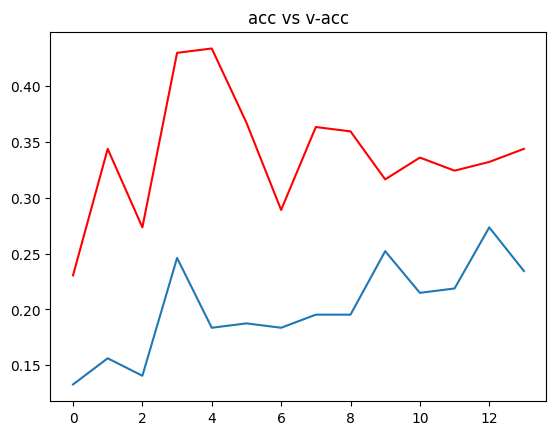

In [27]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],color = 'red')
plt.title("acc vs v-acc")
plt.show()

Text(0.5, 1.0, 'acc vs v-loss')

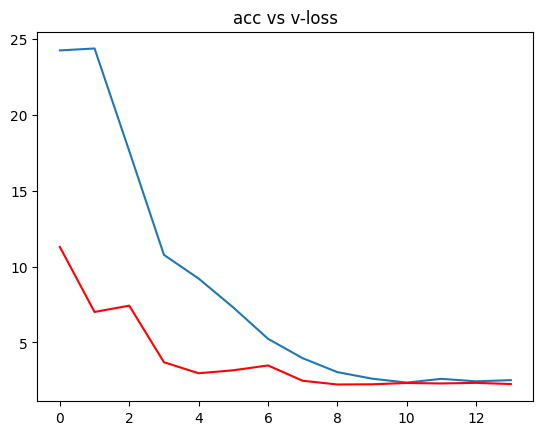

In [28]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],color = 'red')
plt.title("acc vs v-loss")


In [29]:
#load best model
from keras.models import load_model
model = load_model("best_model.h5")

In [30]:
acc = model.evaluate_generator(val)[1]
print(f"The accuracy of model is {acc*100}%")

<ipython-input-30-f62a594ef9bf>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val)[1]


The accuracy of model is 45.19015550613403%


In [31]:
ref = dict(zip(list(train.class_indices.values()) ,  list(train.class_indices.keys())))


In [32]:
def prediction(path):
    img = load_img(path,target_size = (256,256))
    i = img_to_array(img)
    im = preprocess_input(i)
    img = np.expand_dims(im,axis=0)
    pred =np.argmax( model.predict(img))
    print(f"The Image belong to {ref[pred]}")

In [36]:
path = "/content/dataset/dataset/train/Mango (P0)/0001_0008.JPG"
prediction(path)


1/1 [==============================] - 1s 594ms/step
The Image belong to Mango (P0)


In [40]:
path = "/content/lemon.jpg"
prediction(path)

1/1 [==============================] - 1s 618ms/step
The Image belong to Gauva (P3)
